<a href="https://colab.research.google.com/github/yohanesnuwara/reservoir-geomechanics/blob/master/homework%207/homework7_reservoir_geomechanics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Homework 7 Building Geomechanical Model for Barnett Shale**

For reference, see Homework 6

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [0]:
!git clone https://www.github.com/yohanesnuwara/reservoir-geomechanics

Cloning into 'reservoir-geomechanics'...
remote: Enumerating objects: 65, done.
remote: Counting objects: 100% (65/65), done.
remote: Compressing objects: 100% (65/65), done.
remote: Total 200 (delta 28), reused 0 (delta 0), pack-reused 135
Receiving objects: 100% (200/200), 11.51 MiB | 18.79 MiB/s, done.
Resolving deltas: 100% (84/84), done.


Data and knowns

In [0]:
depth = 5725 # ft
Sh_grad = 0.65 # least principal stress gradient, psi/ft
mu = 0.75
Pm_grad = 0.53 # mud weight gradient, psi/ft
Pp_grad = 0.48 # pore pressure gradient, psi/ft
T0 = 0 # tensile strength, psi
Wbo = 0 # wellbore breakout width, degree

# Sv at depth from homework 1
Sv = 6427.27 # psi
# UCS at depth from homework 3, two choices
C0_sonic = 99.65 * 145 # from sonic log empirical eq, to psi
C0_rhob = 103.8 * 145 # from density log empirical eq, to psi

# Pp at depth
Pp = depth * Pp_grad

# Pm at depth
Pm = depth * Pm_grad

$$\frac{S_1-Pp}{S_3-Pp}=(\sqrt{\mu^2+1}+\mu)^2$$

$(\sqrt{\mu^2+1}+\mu)^2$ denoted as `ratio`

In [0]:
ratio = (np.sqrt((mu**2) + 1) + mu)**2
ratio

4.0

Lower bound of least principal stress (in this case `Sh`) is calculated from the above equation

$$Sh=(\frac{Sv-Pp}{(\sqrt{\mu^2+1}+\mu)^2})+Pp$$

In [0]:
Sh_lower = ((Sv - Pp) / ratio) + Pp
print('Lower bound of minimum horizontal stress:', Sh_lower, 'psi')

Lower bound of minimum horizontal stress: 3667.8175 psi


Upper bound of intermediate principal stress (in this case `SH`) is calculated from equation (derived from the very first equation)

$$SH = [(\sqrt{\mu^2+1}+\mu)^2]\cdot(Sv-Pp)+Pp$$

In [0]:
SH_upper = (ratio * (Sv - Pp)) + Pp
print('Upper bound of maximum horizontal stress:', SH_upper, 'psi')

Upper bound of maximum horizontal stress: 17465.08 psi


Construct stress polygon using `zobackogram` function from Homework 6

In [0]:
import sys
sys.path.append('/content/reservoir-geomechanics/homework 6')

([<matplotlib.lines.Line2D at 0x7f4a7596a2e8>],
 [<matplotlib.lines.Line2D at 0x7f4a7596aeb8>])

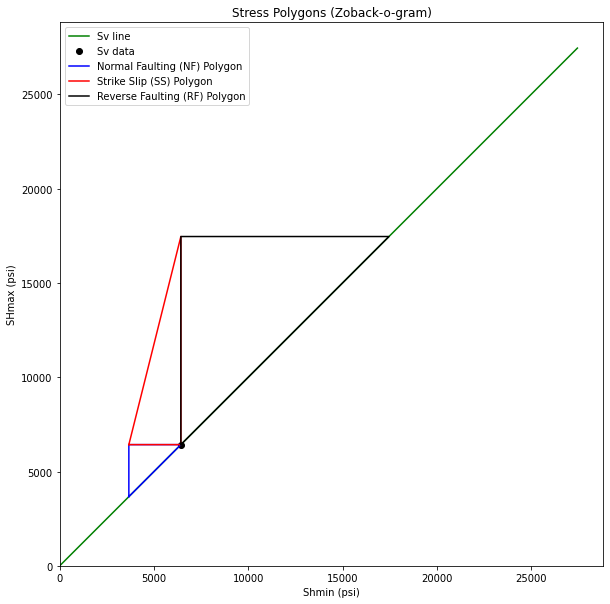

In [0]:
from zobackogram import zobackogram

zobackogram(Sv, Pp, mu)

Plot tensile fracture and wellbore breakout line

In [0]:
def breakout(Sv, Pp, mu, Pm, T0, C0, Wbo):
  import numpy as np
  import matplotlib.pyplot as plt

  # plot zobackogram
  p1, p2, nf, ss, rf = zobackogram(Sv, Pp, mu)

  # ratio of S1-Pp to S3-Pp
  ratio = (np.sqrt((mu**2) + 1) + mu)**2

  # lower limit of Shmin, from Sv
  Sh = ((Sv - Pp) / ratio) + Pp

  # upper limit of SHmax, from Sv and Pp
  SH = (ratio * (Sv - Pp)) + Pp

  # axes of plot
  Sv_x = np.arange(0, (SH + 10000), 10)
  Sv_y = Sv_x

  "Tensile fracture line"
  Sh_line = Sv_x
  SH_tensile = (3 * Sh_line) - ((2 * Pp) + (Pm - Pp)) - T0
  tensile = plt.plot(Sh_line, SH_tensile, '--')

  "Wellbore breakout line"
  SH_breakout = (C0 + (2 * Pp) + (Pm - Pp) - (Sh_line *  (1 + 2 * np.cos(np.deg2rad(180 - Wbo))))) / (1 - 2 * np.cos(np.deg2rad(180 - Wbo)))
  breakout = plt.plot(Sh_line, SH_breakout, '--') 

  plt.legend((p1[0], p2[0], nf[0], ss[0], rf[0], tensile[0], breakout[0]), 
            ['Sv line', 'Sv data', 'Normal Faulting (NF) Polygon', 
              'Strike Slip (SS) Polygon', 'Reverse Faulting (RF) Polygon',
              'Tensile fracture line', 'Wellbore breakout line'])
  return(Sh, SH)

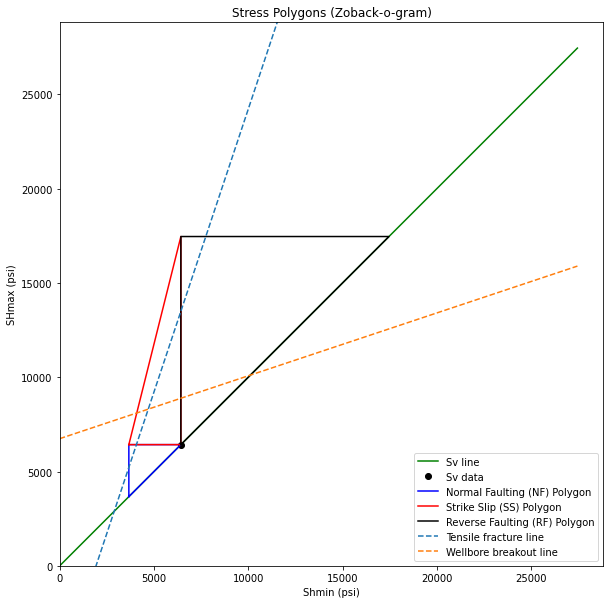

In [0]:
Sh, SH = breakout(Sv, Pp, mu, Pm, T0, C0_sonic, Wbo)

The value of minimum stress from LOT on the polygon

The purple line is the minimum horizontal stress from ISIP data

Minimum horizontal stress from Instantaneuous Shut-in Pressure (ISIP) data: 3721.25 psi 



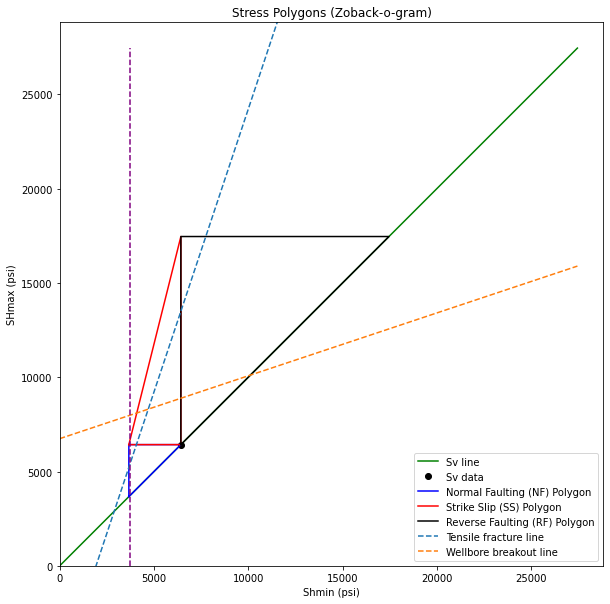

In [0]:
Sh_data = depth * Sh_grad
print('Minimum horizontal stress from Instantaneuous Shut-in Pressure (ISIP) data:', Sh_data, 'psi \n')

sh_x = np.array([Sh_data, Sh_data])
sh_y = np.array([0, SH+10000])

breakout(Sv, Pp, mu, Pm, T0, C0_sonic, Wbo)
plt.plot(sh_x, sh_y, '--', color='purple')

Zooming in

(0.0, 11000.0)

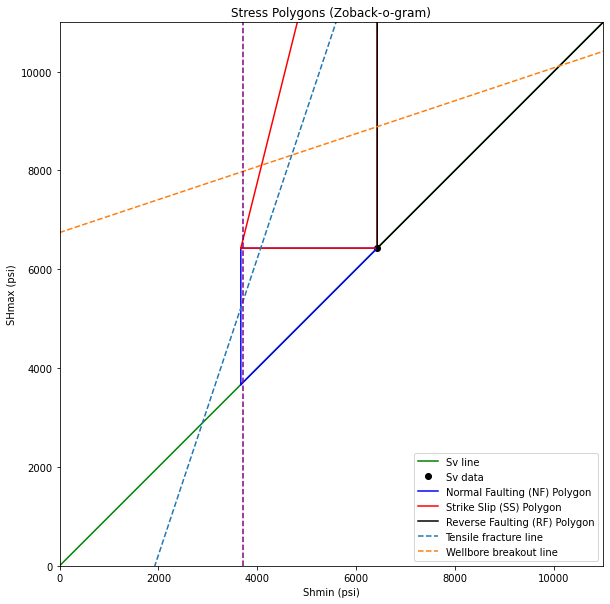

In [0]:
breakout(Sv, Pp, mu, Pm, T0, C0_sonic, Wbo)
plt.plot(sh_x, sh_y, '--', color='purple')
plt.xlim(0,11000); plt.ylim(0,11000)

## Constraints of stresses

### Tensile fracture

Implicit equation for tensile fracture line is:

$$Sh+SH-2(SH-Sh)-2P_p-(P_m-P_p) = T_0$$

Solving for $SH$, explicit equation becomes:

$$SH=3Sh - (T_0+2P_p+(P_m-P_p))$$

Criteria for no tensile fracture occurs when:

$$Sh+SH-2(SH-Sh)-2P_p-(P_m-P_p)\geq T_0$$

So, $SH$ is explicitly:

$$SH\leq 3Sh - (T_0+2P_p+(P_m-P_p))$$

Or $SH$ must be below the tensile line

### Wellbore breakout

Implicit equation for the breakout line is: 

$$Sh+SH-2(SH-Sh)\cos(\pi-W_{bo})-2P_p-(P_m-P_p)=C_0$$

Solving for $SH$, explicit equation becomes:

$$SH=\frac{C_0+2P_p+(P_m-P_p)-Sh(1+2\cos(\pi-W_{bo}))}{1-2\cos(\pi-W_{bo})}$$

Criteria for no wellbore breakout occurs when:

$$Sh+SH-2(SH-Sh)\cos(\pi-W_{bo})-2P_p-(P_m-P_p) \geq C_0$$

So, $SH$ is explicitly:

$$SH \leq \frac{C_0+2P_p+(P_m-P_p)-Sh(1+2\cos(\pi-W_{bo}))}{1-2\cos(\pi-W_{bo})}$$

Or $SH$ must be below the breakout line

### Corner point 1: lowermost point in NF regime on $SH=Sh$ line

In [0]:
# minimum stress
Sh1 = Sh_lower
print("Minimum horizontal stress at point 1:", Sh1, "psi")

# maximum stress
SH1 = Sh1
print("Maximum horizontal stress at point 1:", SH1, "psi")

Minimum horizontal stress at point 1: 3667.8175 psi
Maximum horizontal stress at point 1: 3667.8175 psi


### Corner point 2: intersection between tensile line and lower bound of Shmin in NF regime

In [0]:
# minimum stress
Sh2 = Sh_lower
print("Minimum horizontal stress at point 2:", Sh2, "psi")

# maximum stress
SH2 = (3 * Sh2) - ((2 * Pp) + (Pm - Pp))
print("Maximum horizontal stress at point 2:", SH2, "psi")

Minimum horizontal stress at point 2: 3667.8175 psi
Maximum horizontal stress at point 2: 5221.202499999999 psi


### Corner point 3: intersection between tensile line and breakout line in SS regime

In [0]:
# Solving Sh and SH simultaneously

from scipy.optimize import fsolve

def f(y):
  Sh, SH = y
  # tensile line
  f1 = (3 * Sh) - ((2 * Pp) + (Pm - Pp)) - T0 - SH
  # breakout line
  f2 = ((C0_sonic + (2 * Pp) + (Pm - Pp) - (Sh *  (1 + 2 * np.cos(np.deg2rad(180 - Wbo))))) / (1 - 2 * np.cos(np.deg2rad(180 - Wbo)))) - SH
  return[f1, f2]

solve = fsolve(f, [1, 1]) # initial guess

# minimum stress
Sh3 = solve[0]
print("Minimum horizontal stress at point 3:", Sh3, "psi")

# maximum stress
SH3 = solve[1]
print("Maximum horizontal stress at point 3:", SH3, "psi")

Minimum horizontal stress at point 3: 4697.28125 psi
Maximum horizontal stress at point 3: 8309.59375 psi


### Corner point 4: intersection between breakout line and $SH=Sh$ line in RF regime

In [0]:
# Solving Sh and SH simultaneously

from scipy.optimize import fsolve

def f(y):
  Sh, SH = y
  # normal line
  f1 = SH - Sh
  # breakout line
  f2 = ((C0_sonic + (2 * Pp) + (Pm - Pp) - (Sh *  (1 + 2 * np.cos(np.deg2rad(180 - Wbo))))) / (1 - 2 * np.cos(np.deg2rad(180 - Wbo)))) - SH
  return[f1, f2]

solve = fsolve(f, [1, 1]) # initial guess

# minimum stress
Sh4 = solve[0]
print("Minimum horizontal stress at point 4:", Sh4, "psi")

# maximum stress
SH4 = solve[1]
print("Maximum horizontal stress at point 4:", SH4, "psi")

Minimum horizontal stress at point 4: 10115.75 psi
Maximum horizontal stress at point 4: 10115.75 psi


### Plot the constrained area on stress polygon

(0.0, 11000.0)

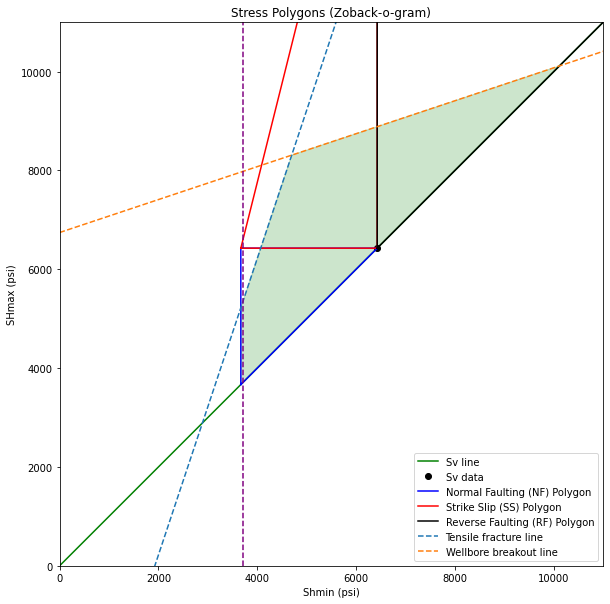

In [0]:
Sh_constrain = [Sh1, Sh2, Sh3, Sh4]
SH_constrain = [SH1, SH2, SH3, SH4]

breakout(Sv, Pp, mu, Pm, T0, C0_sonic, Wbo)
plt.plot(sh_x, sh_y, '--', color='purple')
# fill area
plt.fill(Sh_constrain, SH_constrain, color='green', alpha=0.2)
plt.xlim(0,11000); plt.ylim(0,11000)

## Questions

### Question 1a. From the first homework assignment, what is the overburden stress of the site at 5725 feet depth in psi?

In [0]:
print('The overburden stress at depth 5725 m is:', Sv, 'psi')

The overburden stress at depth 5725 m is: 6427.27 psi


### Question 1b. What is the minimum horizontal stress of the site at 5725 feet depth in psi?

In [0]:
print('The minimum horizontal stress at depth 5725 m is:', Sh_data, 'psi')

The minimum horizontal stress at depth 5725 m is: 3721.25 psi


### Question 1c. What is the pore pressure of the site at 5725 feet depth in psi?

In [0]:
print('The pore pressure at depth 5725 m is:', Pp, 'psi')

The pore pressure at depth 5725 m is: 2748.0 psi


### Question 1d. What is the mud pressure of the site at 5725 feet depth in psi?

In [0]:
print('The mud pressure at depth 5725 m is:', Pm, 'psi')

The mud pressure at depth 5725 m is: 3034.25 psi


### Question 1e. From the third homework assignment, what is the unconfined compressive strength estimated from a sonic log for the Barnett formation of the site at 5725 feet depth in psi?

In [0]:
print('The unconfined compressive strength at depth 5725 m is:', C0_sonic, 'psi')

The unconfined compressive strength at depth 5725 m is: 14449.25 psi


### Question 1f. What is the upper bound of the maximum horizontal stress of the site at 5725 feet depth in psi?

From the intersection of our $Sh$ and the polygons, we know that we are in Normal Faulting (NF) regime.

$Sh$ from ISIP data 3721.25 psi substituted to tensile line

$$SH=3Sh - (T_0+2P_p+(P_m-P_p))$$

In [0]:
SH_upper = (3 * Sh_data) - ((2 * Pp) + (Pm - Pp)) - T0
print('Upper bound of maximum horizontal stress:', SH_upper, 'psi')

Upper bound of maximum horizontal stress: 5381.5 psi


### Question 1g. What is the lower bound of the maximum horizontal stress of the site at 5725 feet depth in psi?

$Sh$ from ISIP data 3721.25 psi substituted to $SH=Sh$ line

In [0]:
SH_lower = Sh_data
print('Lower bound of maximum horizontal stress:', SH_lower, 'psi')

Lower bound of maximum horizontal stress: 3721.25 psi


### Question 1h. What is the value of the upper bound of a ϕ of the site at 5725 feet depth? Enter your answer as a number from 0 to 1

$$\phi=\frac{S_2-S_3}{S_1-S_3}$$

Regime is NF, the stresses are: $Sh<SH<Sv$

Therefore, $S_1=Sv$, $S_2=SH$, and $S_3=Sh$

In [0]:
phi_upper = (SH_upper - Sh_data) / (Sv - Sh_data)
print('Upper bound of phi:', phi_upper)

Upper bound of phi: 0.6135394416892704


### Question 1i. What is the value of the upper bound of an Aϕ of the site at 5725 feet depth? Enter your answer as a number from 0 to 3.

$$A \phi=(n+0.5)+(−1)^n(\phi −0.5)$$

Where $n=0$ for NF regime, $n=1$ for SS regime, $n=2$ for RF regime

In [0]:
n = 0
A_phi_upper = (n + 0.5) + ((-1**n) * (phi - 0.5))
print('Upper bound of (A*phi):', A_phi_upper)

Upper bound of (A*phi): 0.38646055831072956


In [0]:
(5381.5 - 3721.25) / (6427.27 - 3721.25)

0.6135394416892704